# **YOLO OBJECT DETECTION ASSESSMENT**

Tasks :
- The dataset given consists of images of `live` and `spoof` data.
- You may use any open-source YOLO repositories to complete this assessment.
- Please try to complete section by section.
- There are 2 types of assessment to be completed:
  - Code
  - Explanation  

<!-- - Please use images from `train` and `val` -->
<!-- - steps (sections) are given for this tasks (task G is optional) -->
<!-- - detect live or spoof with given dataset
- train and val file for training your model
- test file to verify your results
- you might use any open source yolo resources to done your assignment -->

Note:
- This assessment should be completed in a week. Please manage your time accordingly.
- Ensure that **ALL** code blocks has been executed, including training, evaluation, benchmark and visualizations upon submission.
<!-- - Add comment to your codes.  -->

<!-- note :
- this assessment should be hand done in a week
- any training, evaluation, benchmark and any visualisations results done is a must to run in jupyter notebook or colab notebook so the results can be straight away reviewed without re-run the code
- your training could be a run by cli, code or any library
- pls give explanations for all the results
- if no code is fill in you can comment your explainations
- any idea and thoughts can be commented and outline them
- fill up the explaination in markdown
- fill up the code in code
- you might add more markdown and code section -->

Reference :
- https://pyimagesearch.com/2022/06/20/training-the-yolov5-object-detector-on-a-custom-dataset/
- https://github.com/ultralytics/ultralytics


7 sections to be completed:

A) PREPROCESSING

B) VISUALIZE PREPROCESSED DATA

C) TRAINING

D) FINDINGS AND CONCLUSION

E) EVALUATE ON TEST SETS

F) SUMMARIZE AND IMPROVEMENTS

G) BONUS POINTS

## A) PREPROCESSING
- Dataset Distribution:
  - Train: 120
  - Validation: 20
  - Test: 20
<!-- you are given datasets : 120 for train , 20 for val , 20 for test -->
- Annotation text file is given in the following format:
  - class_index, x-center, y-center, w , h

Task(s):
- Resize image size
- Recalculate resized images' coordinates:
  - x-center_resized, y-center_resized, w_resized , h_resized
- All the results should be in thier respective folder(s):
    - images/train , images/val, image/test
    - labels/train , labels/val, labels/test
    - *HINT: different YOLO versions/ repositories may have different directory format*

In [1]:
!nvidia-smi

Thu Aug 29 10:58:42 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.76                 Driver Version: 560.76         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce MX250         WDDM  |   00000000:02:00.0 Off |                  N/A |
| N/A   59C    P8             N/A / ERR!  |       0MiB /   2048MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
import sys
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ultralytics import YOLO
from ultralytics.utils.benchmarks import benchmark
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline
from IPython.display import display, Image

# Add the project root to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
  sys.path.append(project_root)

from utils import draw

In [3]:
dataset_raw_path = '../data/raw'
dataset_processed_path = '../data/processed'

In [4]:
with open(f'{dataset_raw_path}/train.txt', 'r') as file:
  train_dirs = [line.strip() for line in file]

with open(f'{dataset_raw_path}/val.txt', 'r') as file:
  val_dirs = [line.strip() for line in file]

with open(f'{dataset_raw_path}/test.txt', 'r') as file:
  test_dirs = [line.strip() for line in file]

In [5]:
base_dirs = [f'{dataset_processed_path}/images', f'{dataset_processed_path}/labels']
sub_dirs = ['train', 'val', 'test']

for base in base_dirs:
  for sub in sub_dirs:
    os.makedirs(os.path.join(base, sub), exist_ok=True)

In [6]:
for split, dirs in zip(['train', 'val', 'test'], [train_dirs, val_dirs, test_dirs]):
  for dir in tqdm(dirs, desc=f'Processing {split} split'):
    filename = os.path.splitext(os.path.basename(dir))[0]

    # Resize image
    img = cv2.imread(f'{dataset_raw_path}/images/{split}/{filename}.png')
    h_old, w_old = img.shape[:2]
    h_new, w_new = 640, 640
    resized_img = cv2.resize(img, (h_new, w_new))
    cv2.imwrite(f'{dataset_processed_path}/images/{split}/{filename}.png', resized_img)

    # Resize label
    scale_x = w_new / w_old
    scale_y = h_new / h_old

    with open(f'{dataset_raw_path}/labels/{split}/{filename}.txt', 'r') as file:
      line = file.readline().strip().split()
      label = int(line[0])
      x_center = float(line[1])
      y_center = float(line[2])
      w_bbox = int(line[3])
      h_bbox = int(line[4])

      # Resize and normalize
      x_center_resized = x_center * scale_x / w_new
      y_center_resized = y_center * scale_y / h_new
      w_resized = w_bbox * scale_x / w_new
      h_resized = h_bbox * scale_y / h_new

    with open(f'{dataset_processed_path}/labels/{split}/{filename}.txt', 'w') as file:
      file.write(f'{label} {x_center_resized} {y_center_resized} {w_resized} {h_resized}')

Processing test split: 100%|██████████| 20/20 [00:01<00:00, 13.20it/s]


## B) VISUALIZE PREPROCESSED DATA
- draw bounding box on any 10 images from task A to verify processed datasets and coordinates

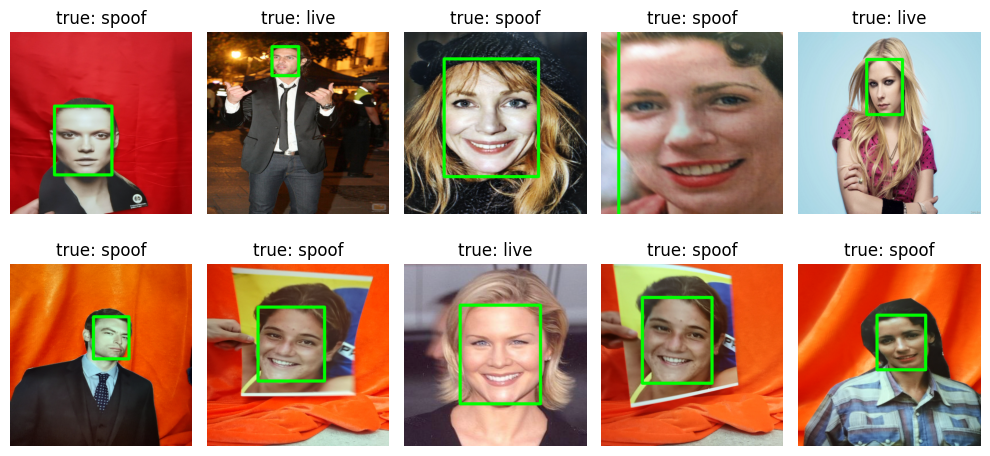

In [7]:
# Folder paths
image_folder = f'{dataset_processed_path}/images/train'
label_folder = f'{dataset_processed_path}/labels/train'

# Get the first 10 image files
image_files = sorted(os.listdir(image_folder))[:10]

# Create a 2 by 5 subplot
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, image_file in enumerate(image_files):
  # Read the image
  img_path = os.path.join(image_folder, image_file)
  img = cv2.imread(img_path)
  h, w = img.shape[:2]
  
  # Read the corresponding label
  label_path = os.path.join(label_folder, os.path.splitext(image_file)[0] + '.txt')
  with open(label_path, 'r') as file:
    line = file.readline().strip().split()
    label = 'spoof' if int(line[0]) else 'live'
    x_center = float(line[1]) * w
    y_center = float(line[2]) * h
    w_bbox = float(line[3]) * w
    h_bbox = float(line[4]) * h
  
  # Draw the bounding box on the image
  draw.draw_bbox(img, x_center, y_center, w_bbox, h_bbox, (0, 255, 0))
  
  # Convert the image from BGR to RGB
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  
  # Plot the image in the subplot
  ax = axes[i // 5, i % 5]
  ax.imshow(img_rgb)
  ax.axis('off')
  ax.set_title(f'true: {label}')

plt.tight_layout()
plt.show()

## C) TRAINING

- Please include your training parameters. (screenshot/ in written form)
<!-- pls include your configuration written here all screenshot of your parameters setup and etc -->
- Specify your output directory path.
  - Model
  - Plots
  - Images (if you have any)

*Hints : according to yolo, you need to have the following files:*
  - hyp yaml file
  - dataset yaml file
  - model yaml file

In [8]:
# Load model
model = YOLO("yolov8n.yaml")  # build a new model from YAML
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)
model = YOLO("yolov8n.yaml").load("yolov8n.pt")  # build from YAML and transfer weights

100%|██████████| 6.25M/6.25M [00:27<00:00, 240kB/s]


Transferred 355/355 items from pretrained weights


In [ ]:
# Train the model
results = model.train(data='../config/dataset.yaml', epochs=100, patience=100, batch=16, 
                      imgsz=640, save=True, save_period=10, device=[0], project='../runs', 
                      pretrained=True, optimizer='auto', seed=42)

# The detailed hyperparameters could be found at '../runs/detect/train/args.yaml'

In [ ]:
# Benchmark on GPU
benchmark(model="yolov8n.pt", data='../config/dataset.yaml', imgsz=640, half=False, device=0)

## D) FINDINGS
- Please state your findings on:
  - Benchmark
  - Performance
  - Visualization

### 1. Confusion Matrix

The confusion matrix is a table used to evaluate the performance of a classification model. It shows the actual versus predicted classifications made by the model.

Based on the confusion matrix: 
- 10 *live* samples predicted as *live*.
- 9 *spoof* samples predicted as *spoof*, 1 *spoof* predicted as *live*.
- 1 *background* sample predicted as *background*.

In anti-spoofing systems, if we define *spoof* as "POSITIVE" and *live* as "NEGATIVE", we care about false negatives (FN), because predicting "spoof" as "live" is detrimental. Thus we need to ensure that the number of FNs is lower as possible, thus we want a high recall regarding the performance of our model.


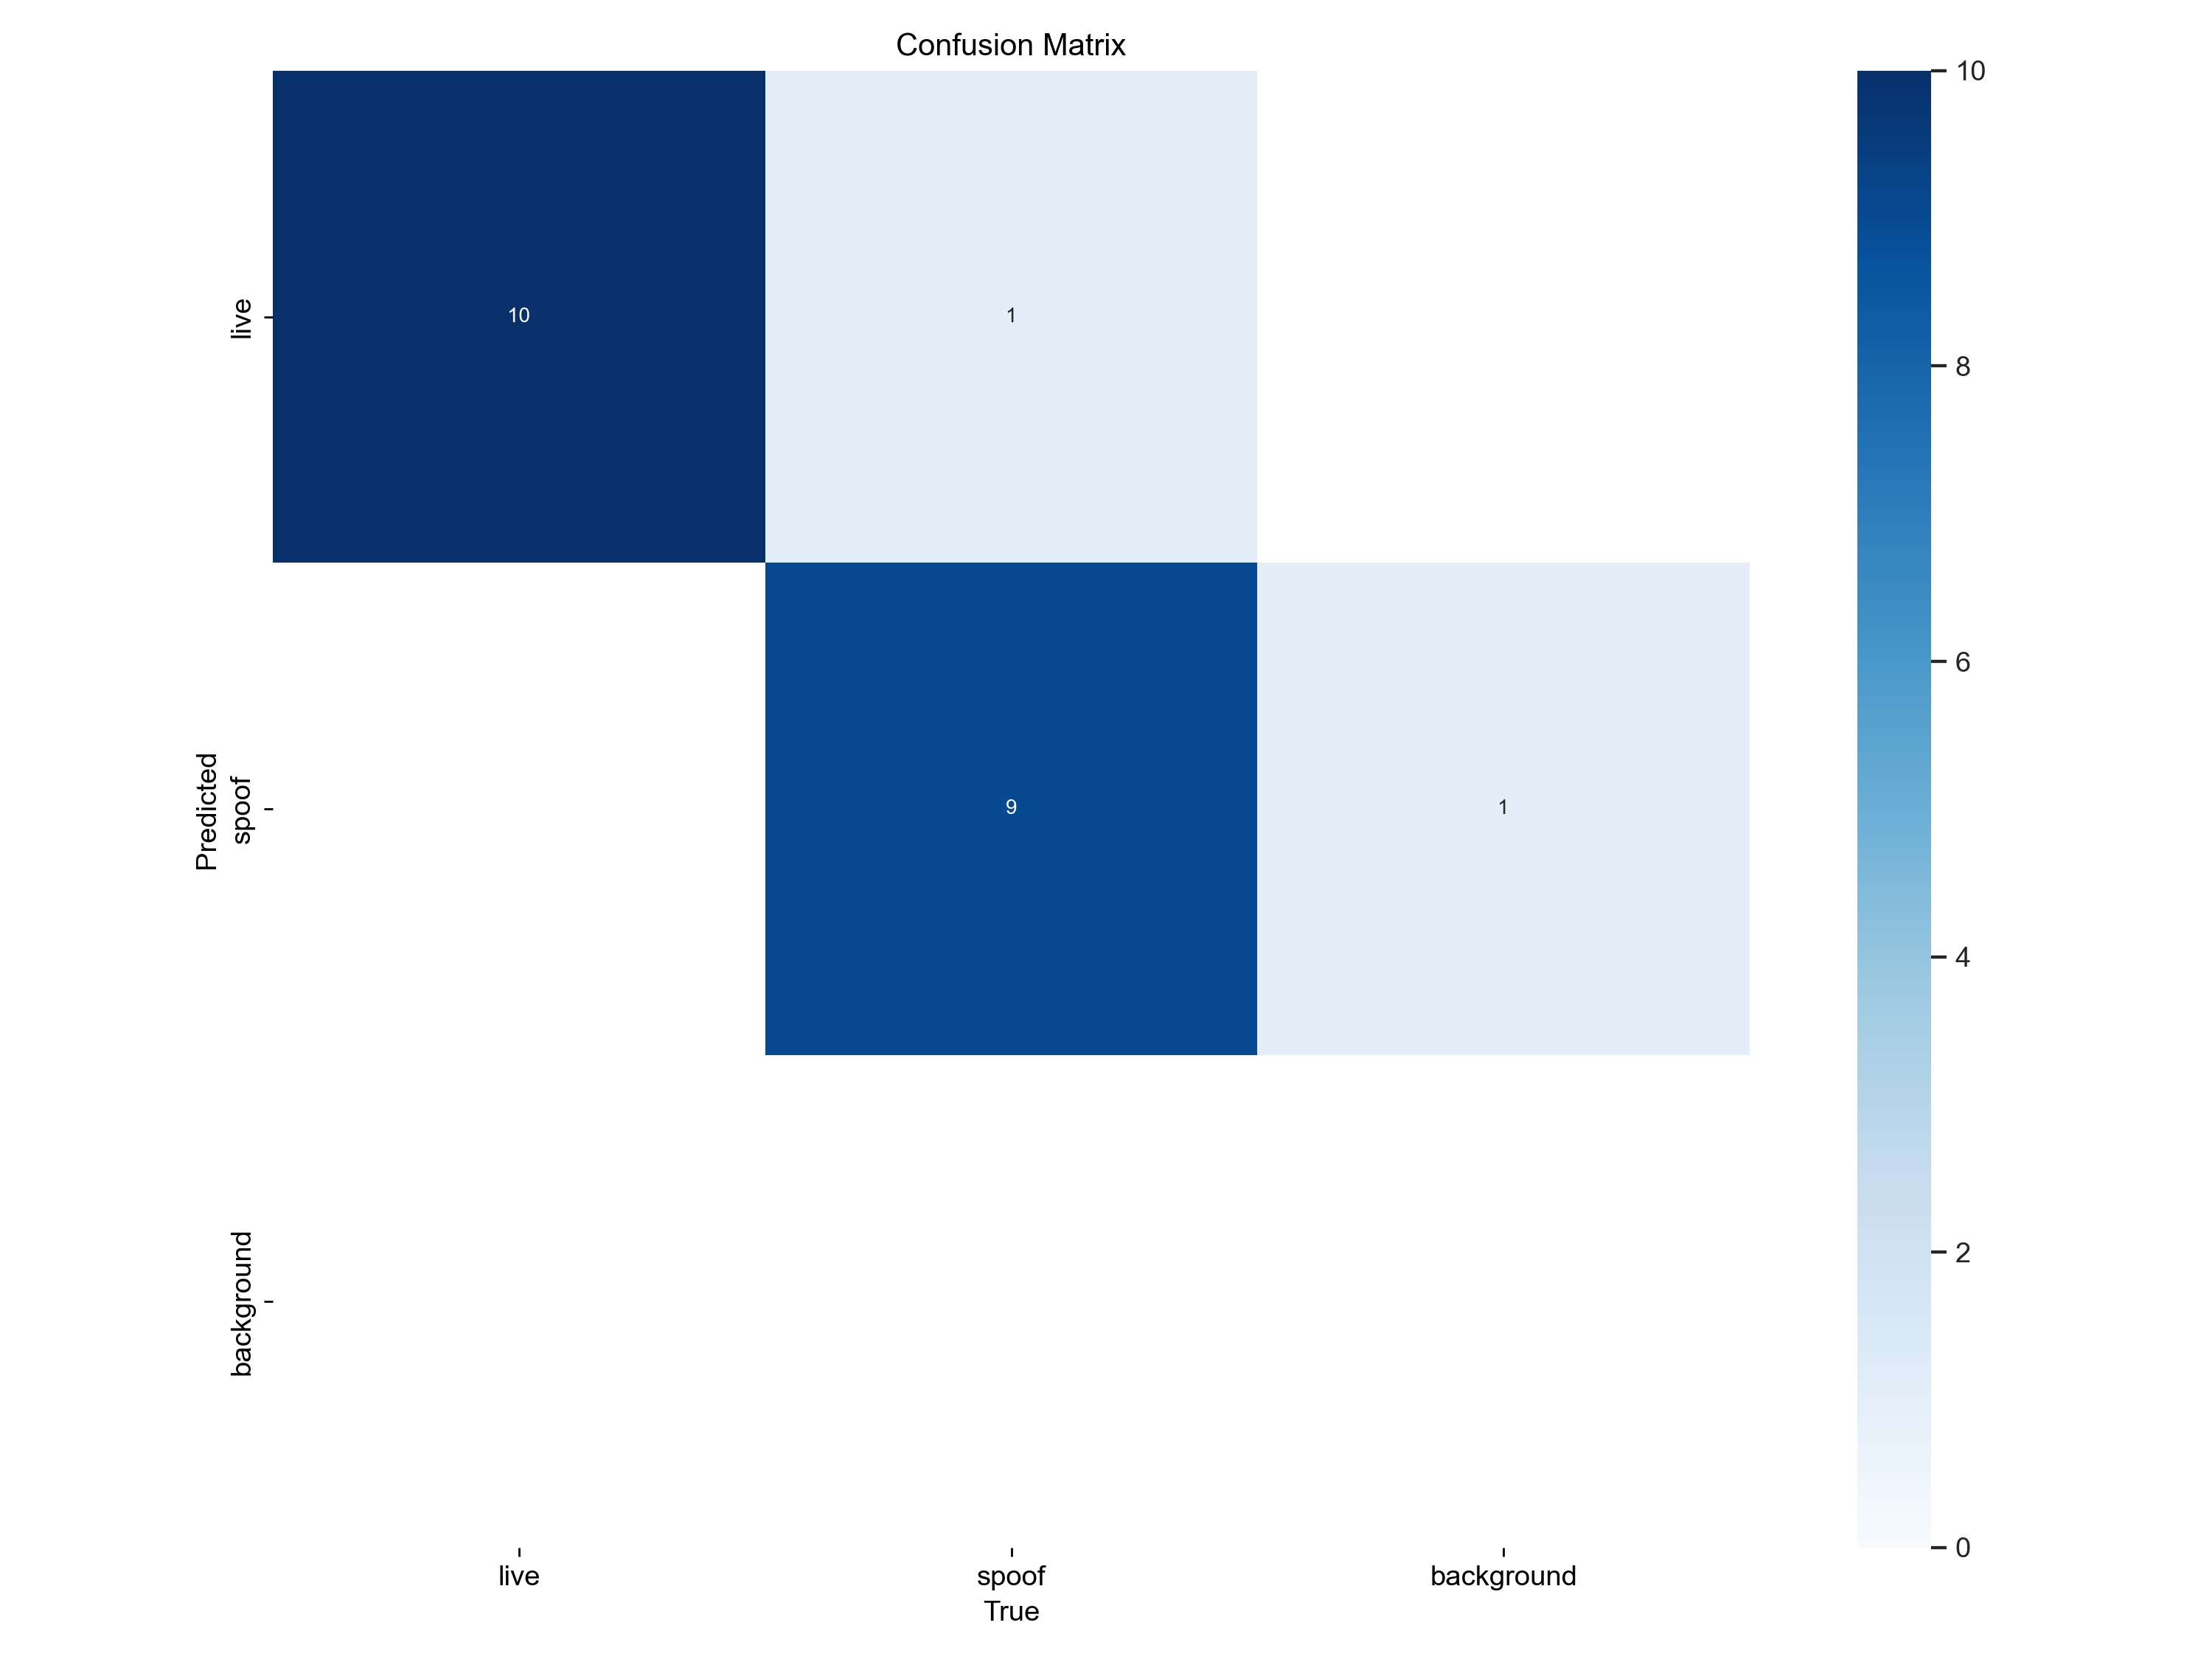

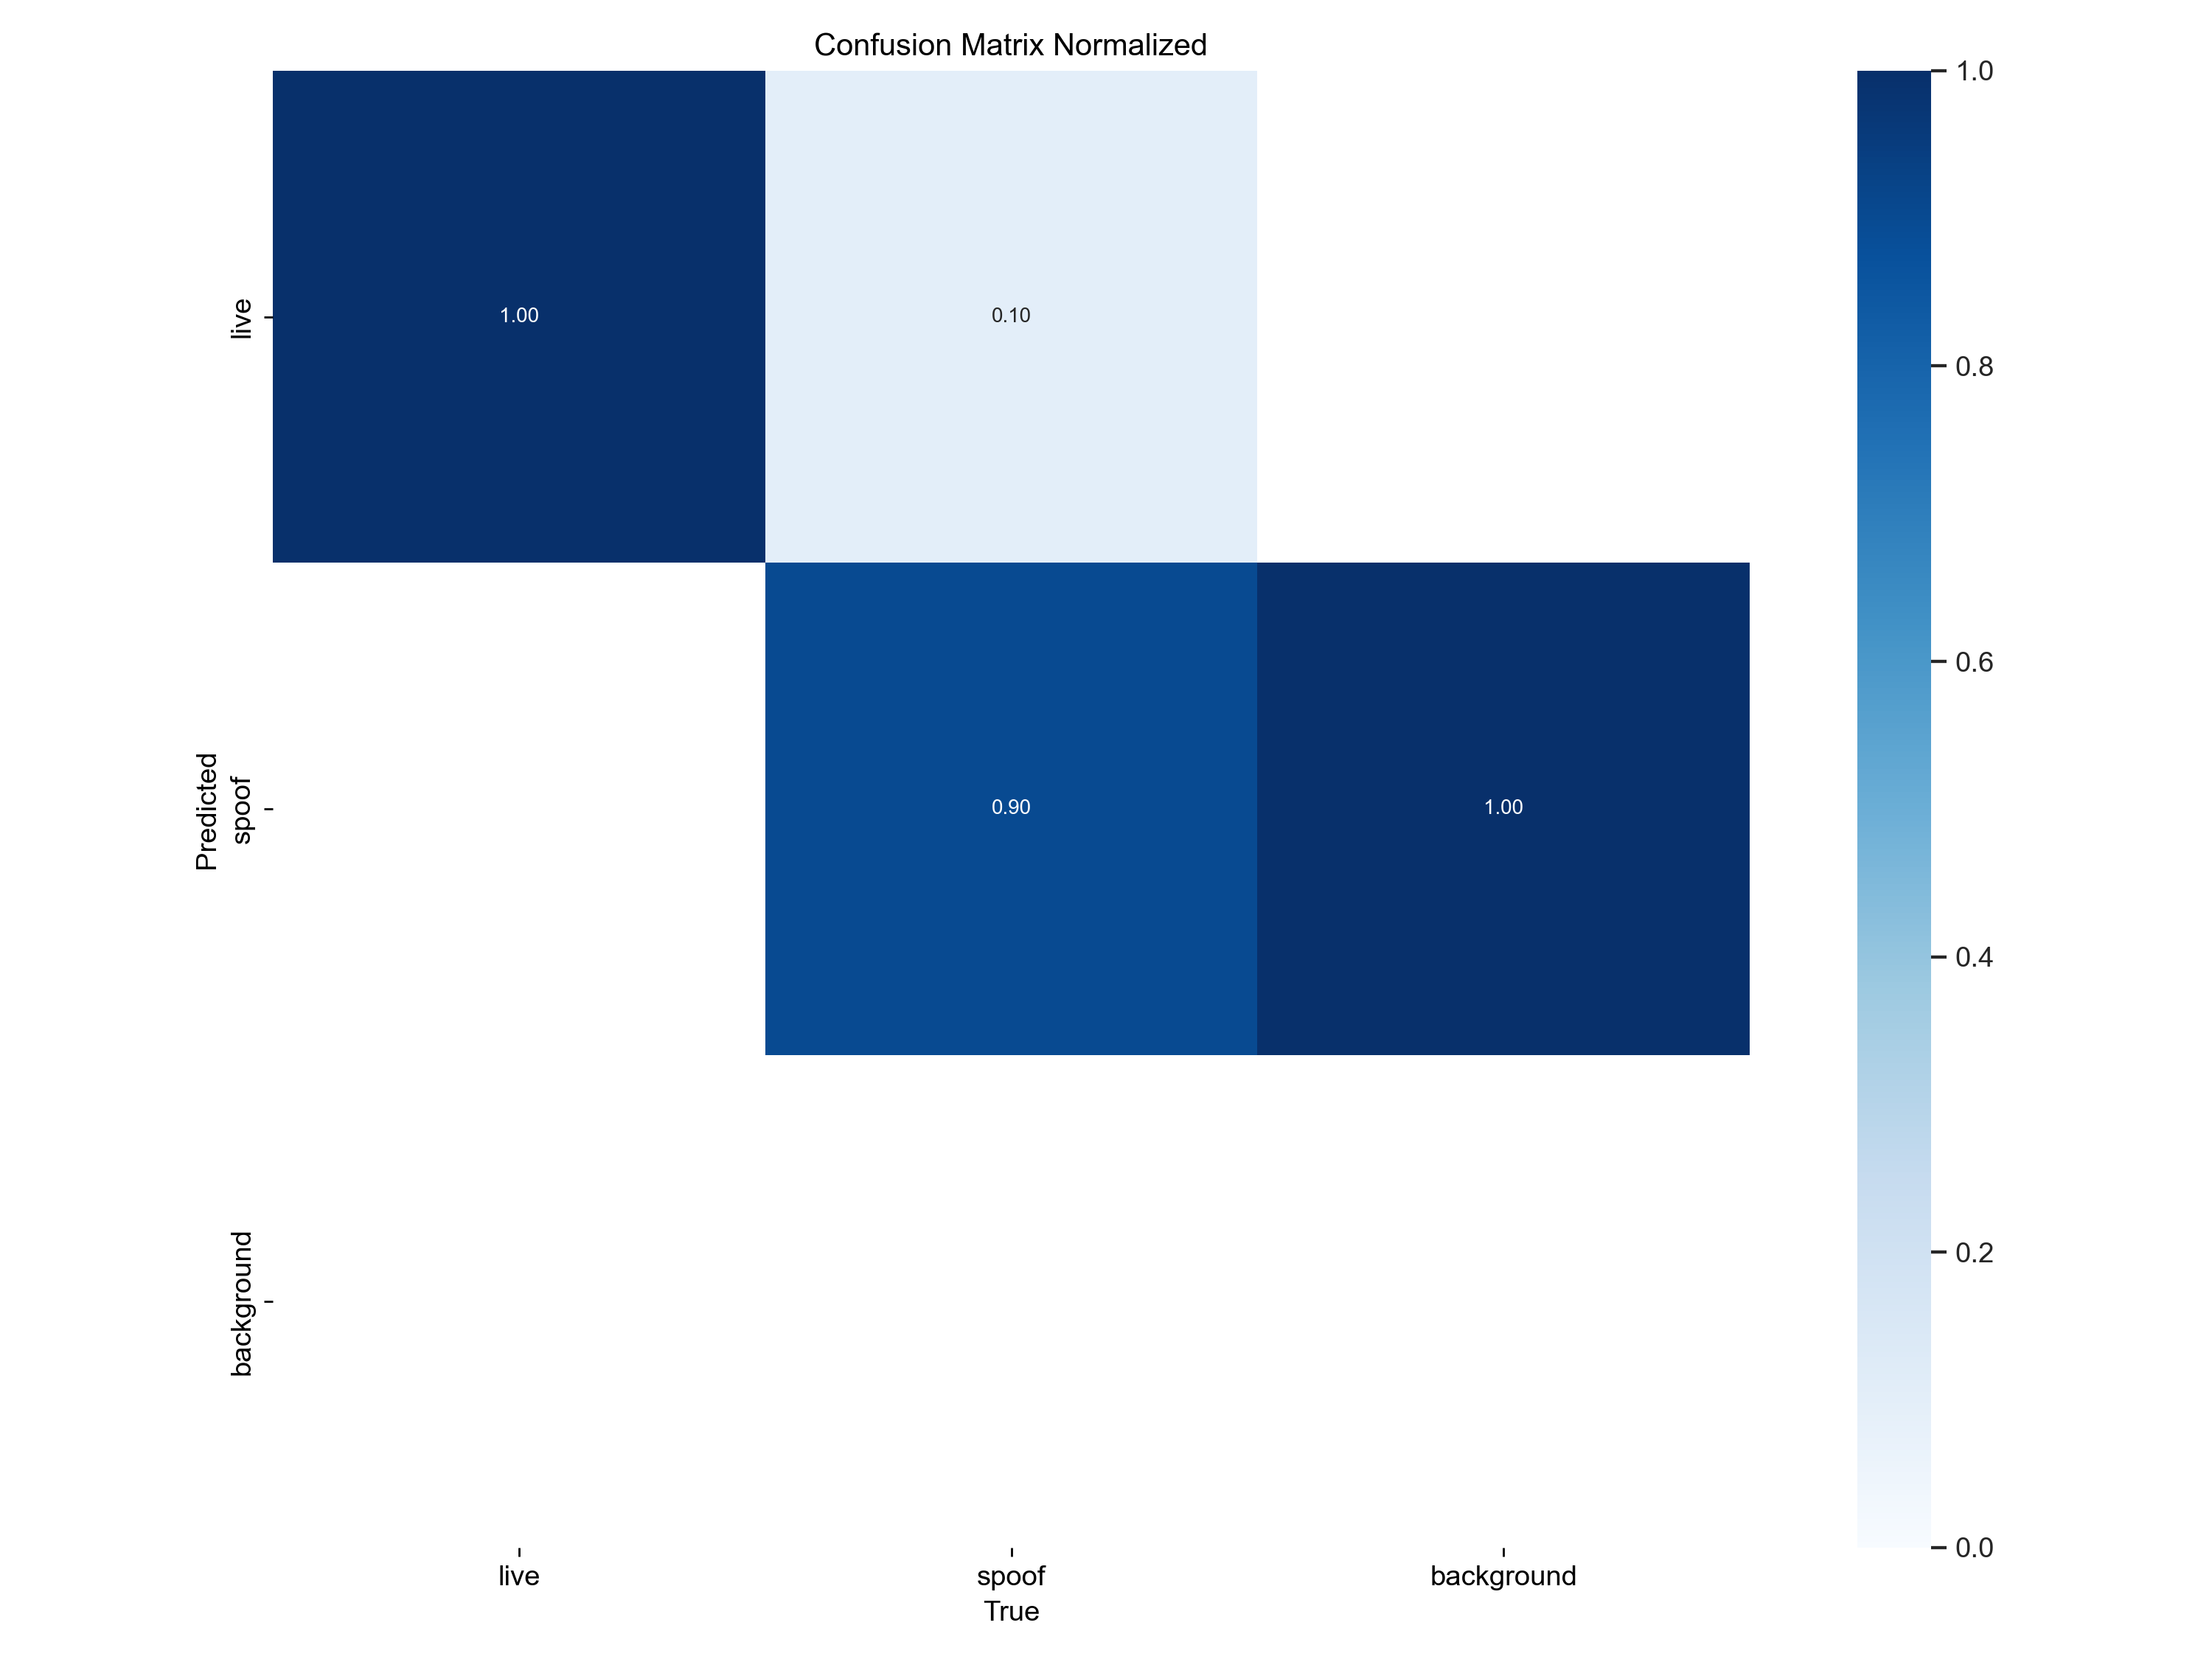

In [10]:
# save_dir = results.save_dir 
save_dir = '../runs/detect/train'

for img_name in ['confusion_matrix.png', 'confusion_matrix_normalized.png']:
  display(Image(filename=f'{save_dir}/{img_name}', width=600))

### 2. Overall Training Results

Results at the 30th epoch

**Losses**
| train/box_loss | train/cls_loss | train/dfl_loss | val/box_loss | val/cls_loss | val/dfl_loss |
| - | - | - | - | - | - |
| 0.5573 | 1.1774 | 0.9851 | 0.6226 | 0.8096 | 0.9506 |

**Metrics**
 metrics/precision(B) | metrics/recall(B) | metrics/mAP50(B) | metrics/mAP50-95(B) |
 | - | - | - | - |
 | 0.9355 | 0.9500 | 0.9814 | 0.8311 |

For box_loss, cls_loss, dfl_loss the overall trend is the losses gradually decreases as the model learns to predict more accurate bounding boxes. This trend is applicable to both training and validation, and the difference between the losses of training and validation does not have a huge gap, thus the model does not suffer from overfitting.

There are 4 metrics selected to evaluate the performance of the model: Precision, Recall, mAP50, mAP50-95. Other than recall, the remaning metrics increases gradually. Recall fluctuates before the model converges.

- **Precision-Confidence Curve:** Precision should generally increase as confidence increases. 
- **Recall-Confidence Curve:** Recall should generally decrease as confidence increases.
- **F1-Confidence Curve:** The F1 score, which is the harmonic mean of precision and recall, will generally peak at some confidence threshold where the balance between precision and recall is optimal. 
- **Precision-Recall Curve:** The curve should be close to the top-right corner, indicating high precision and high recall.

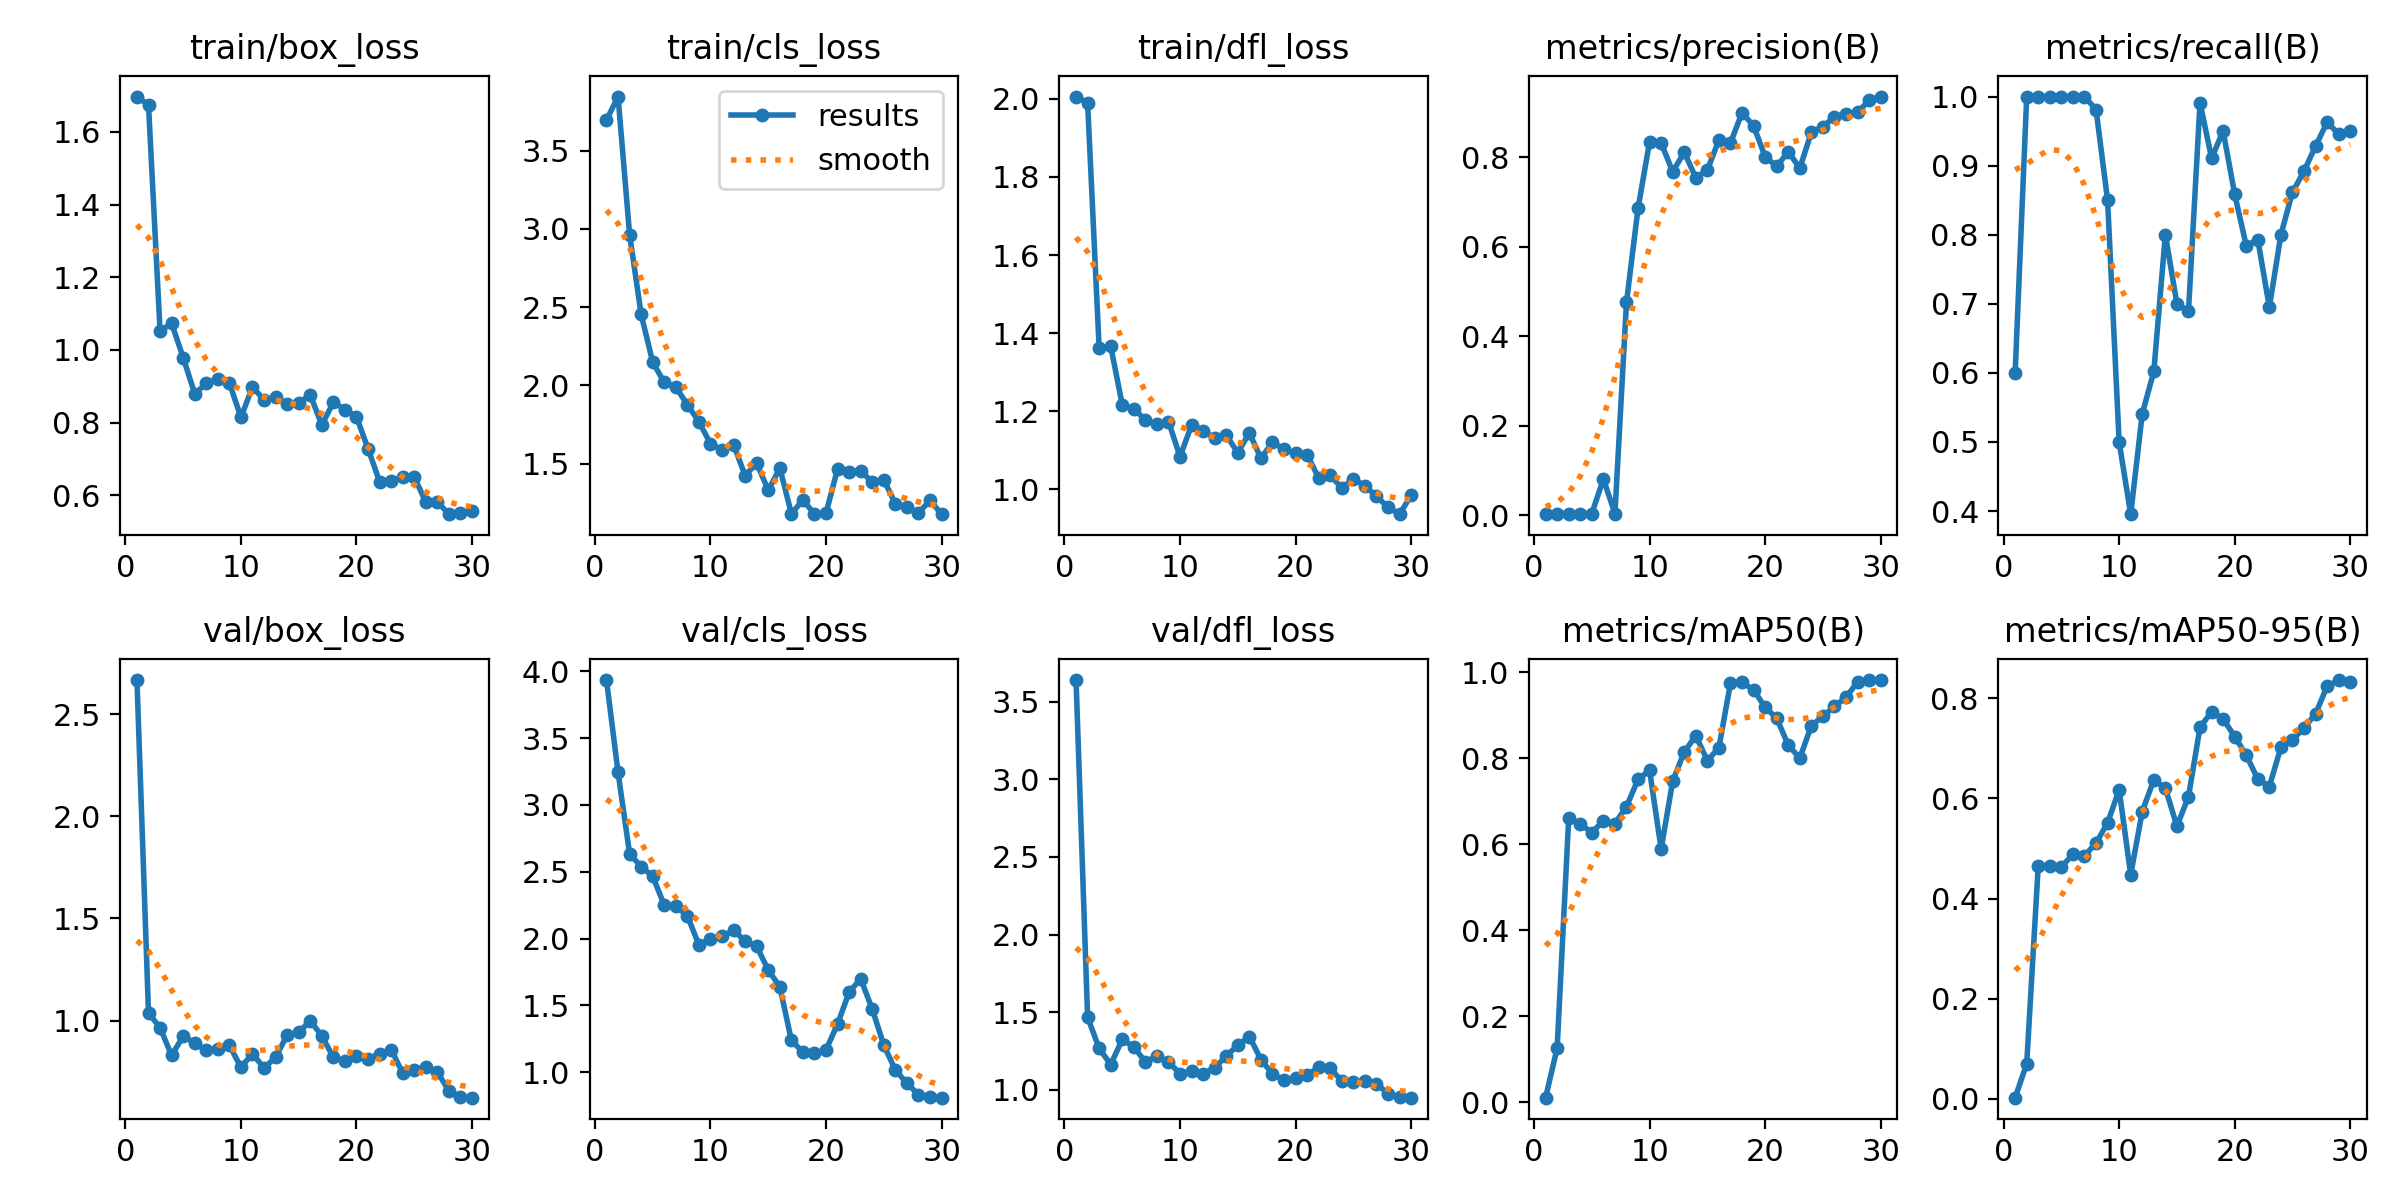

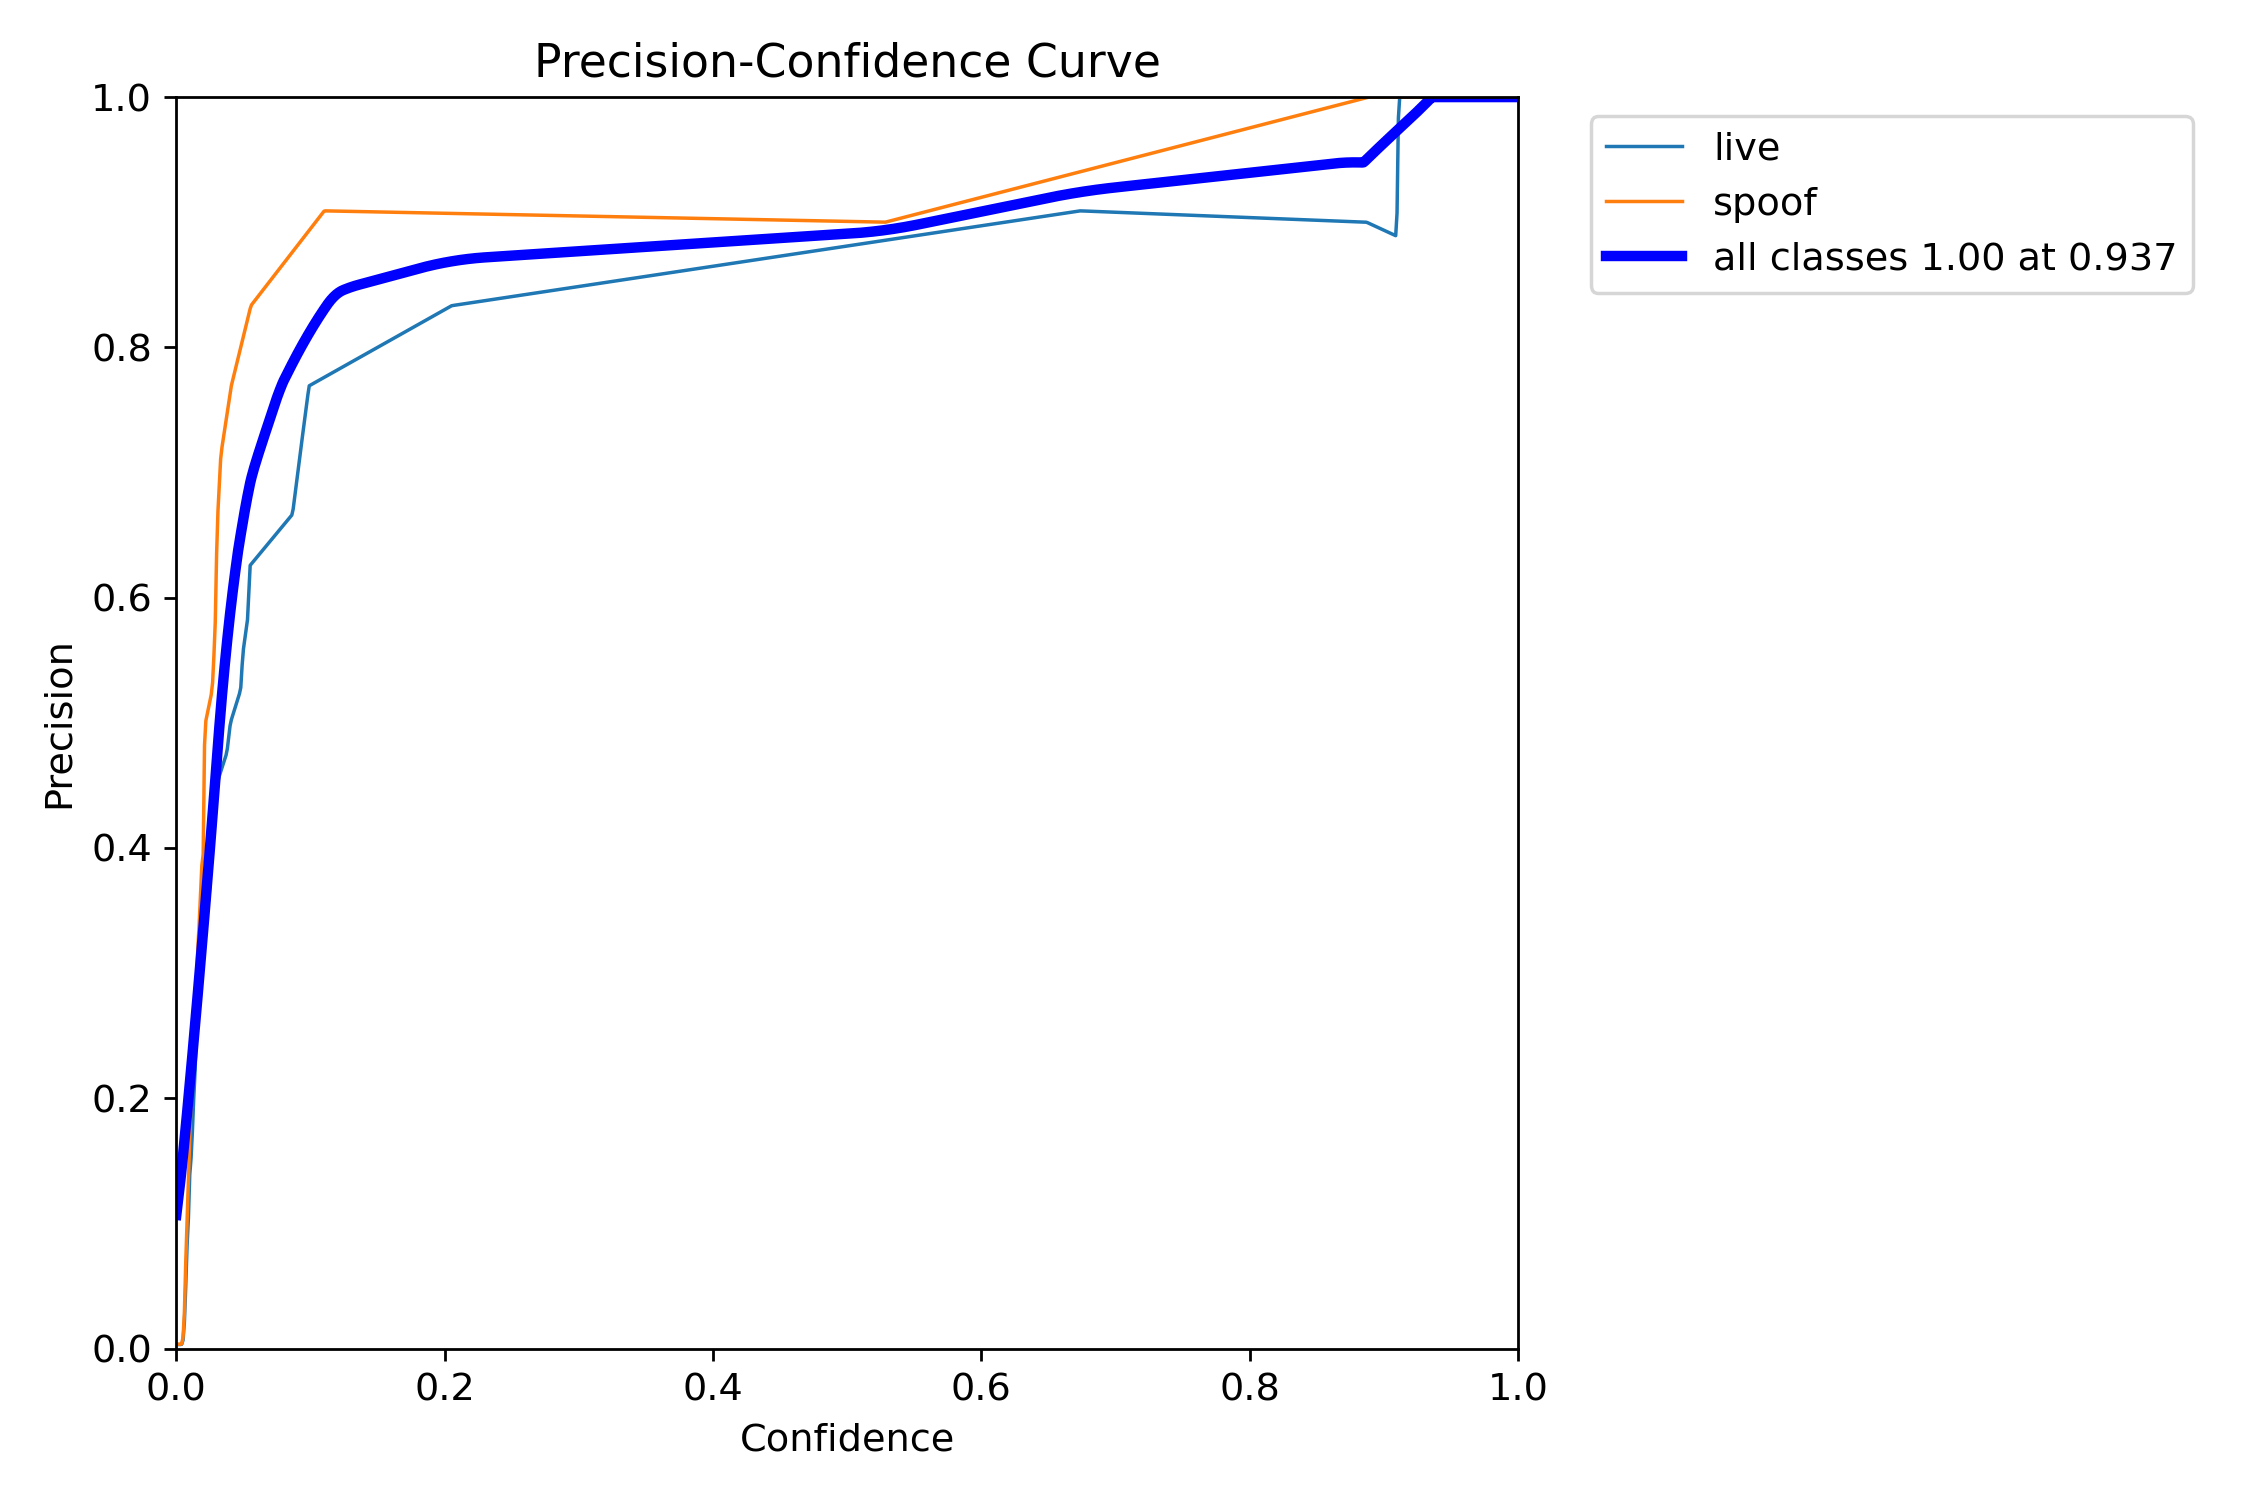

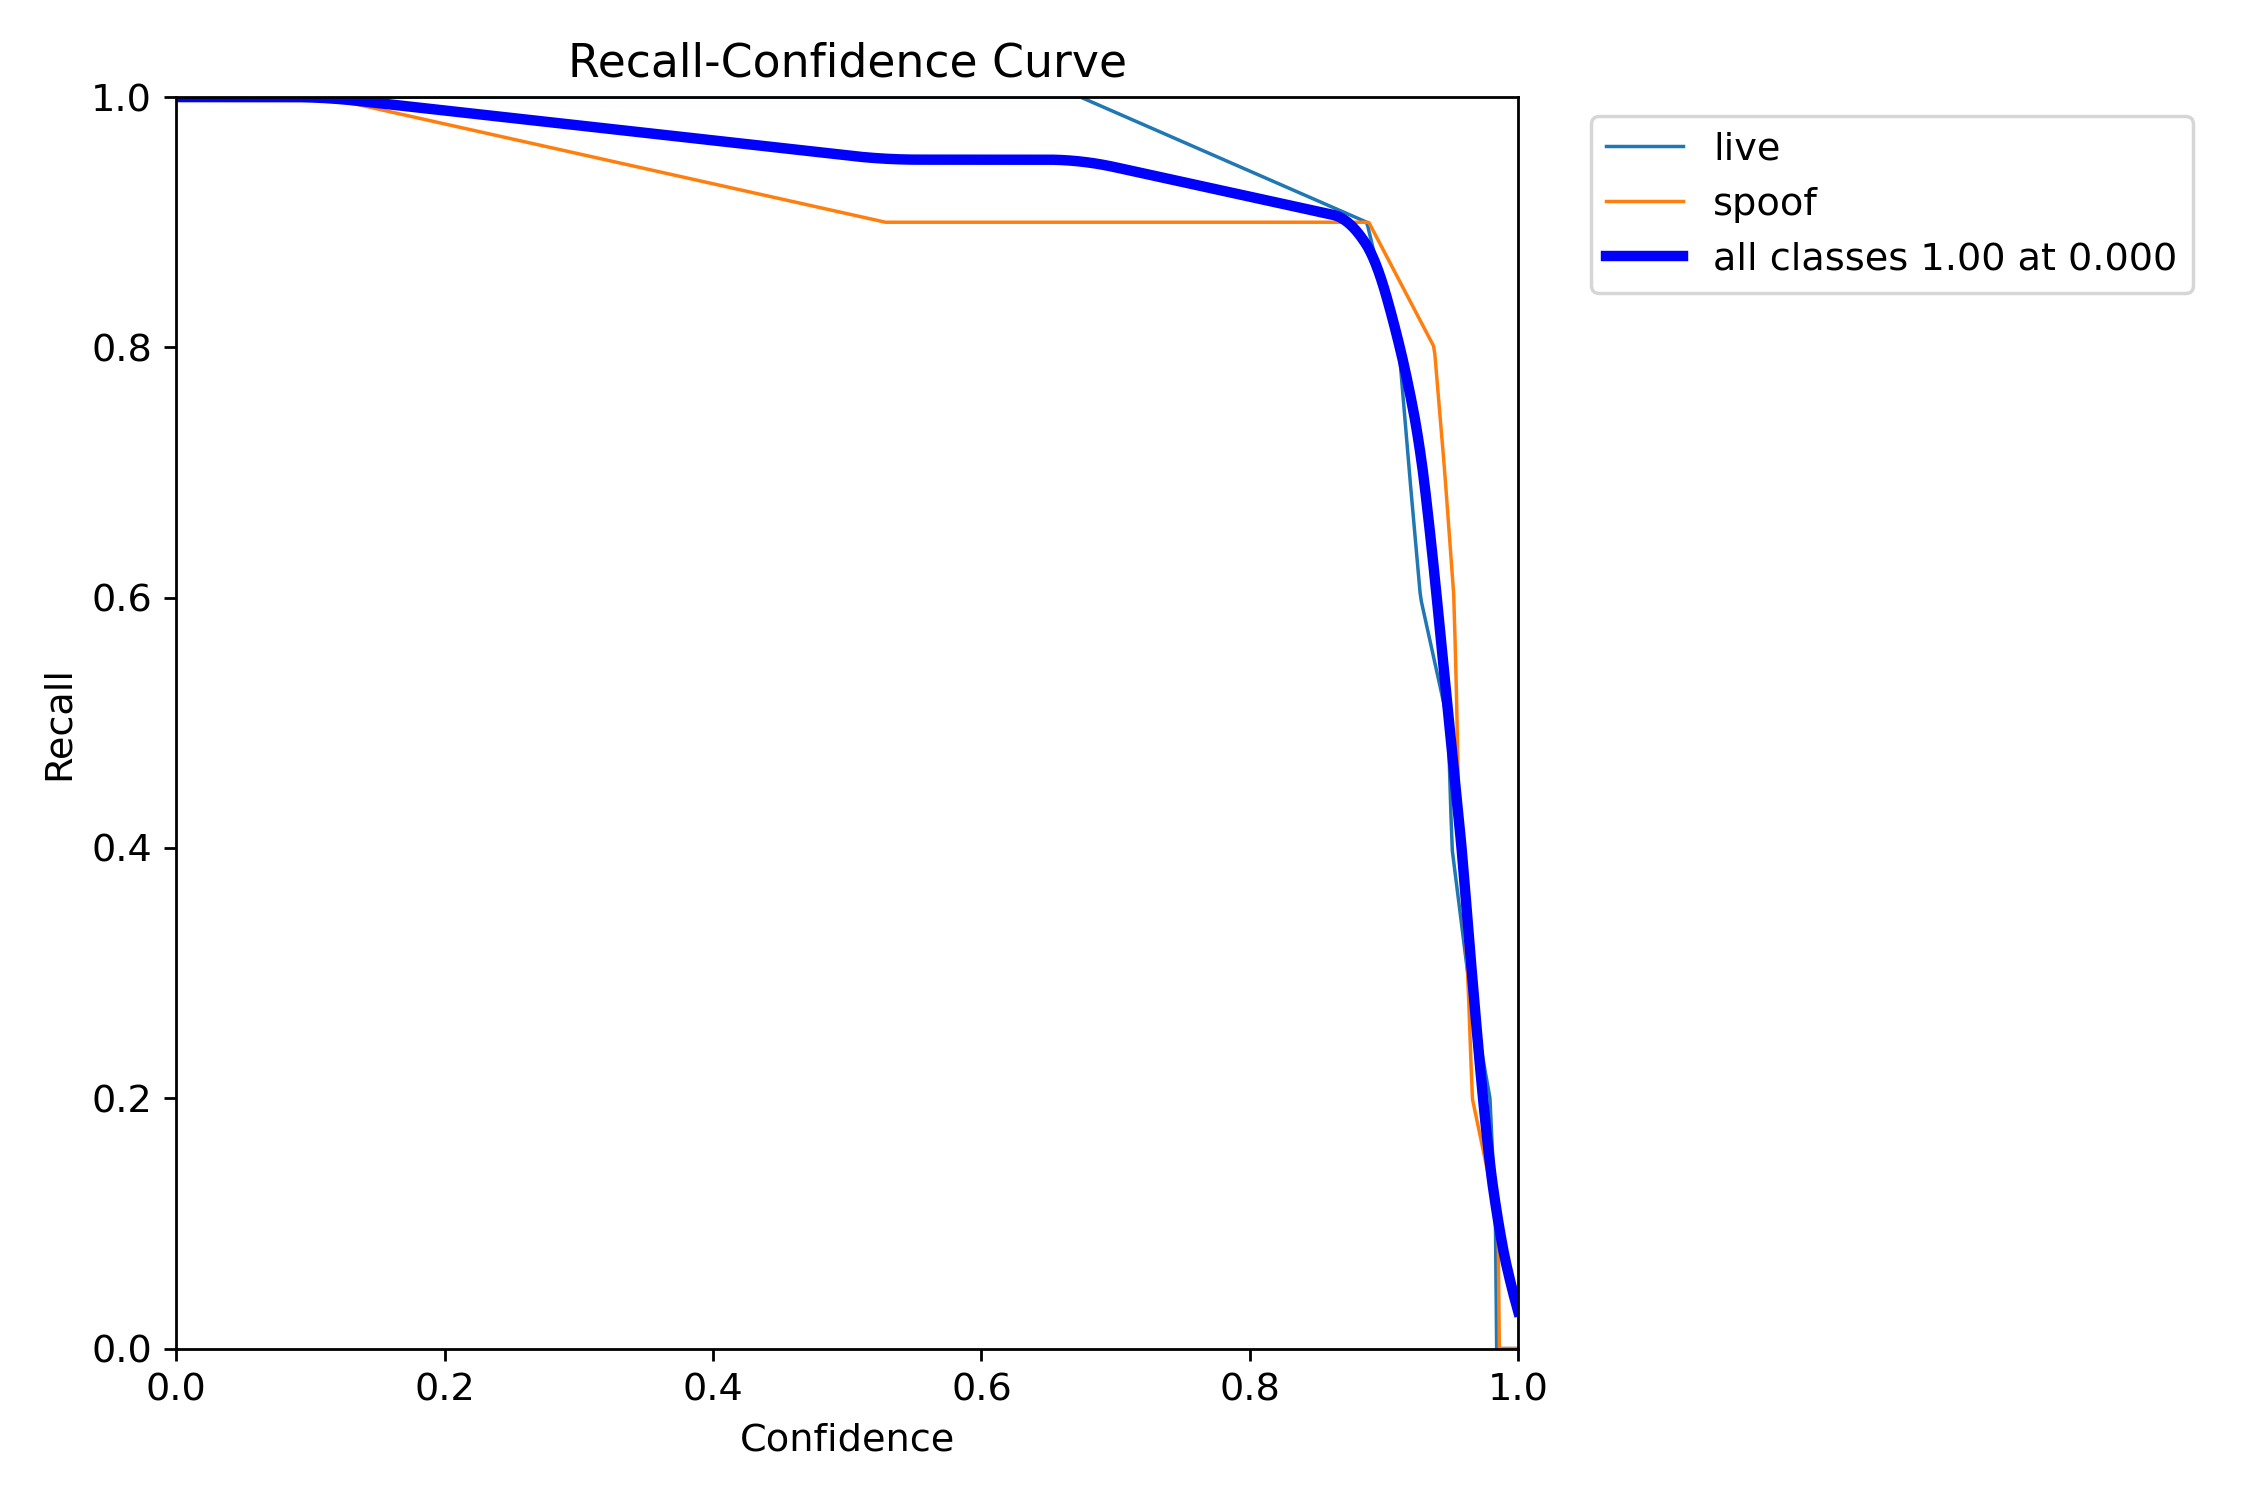

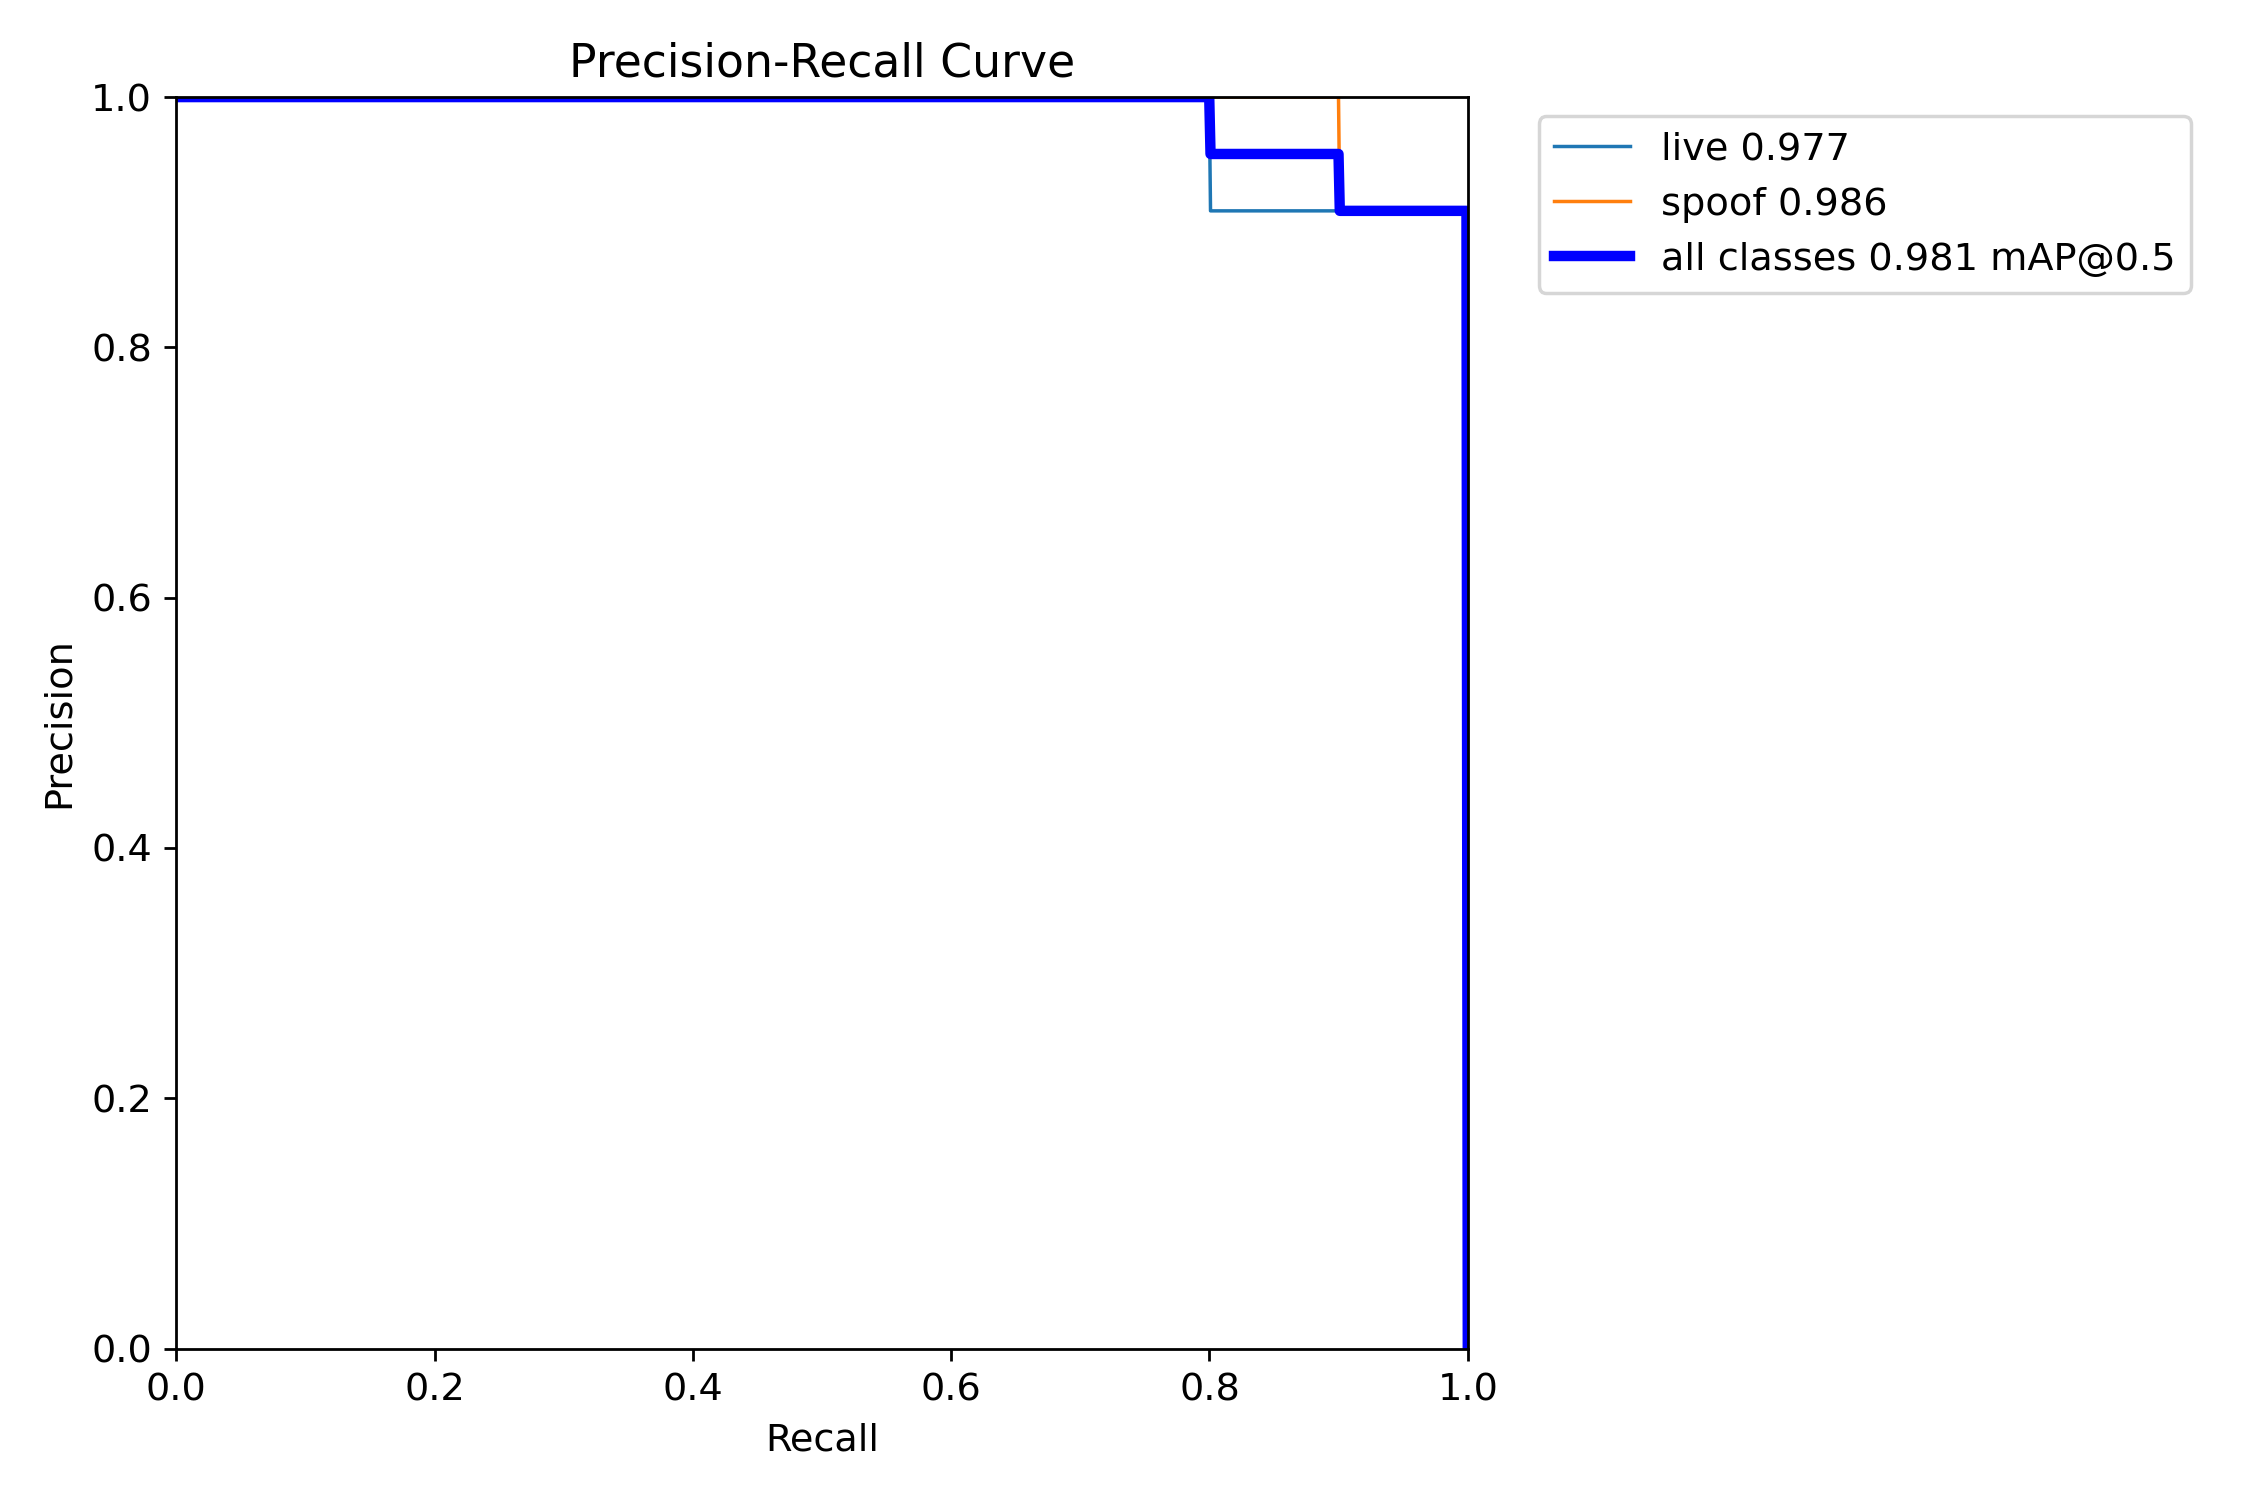

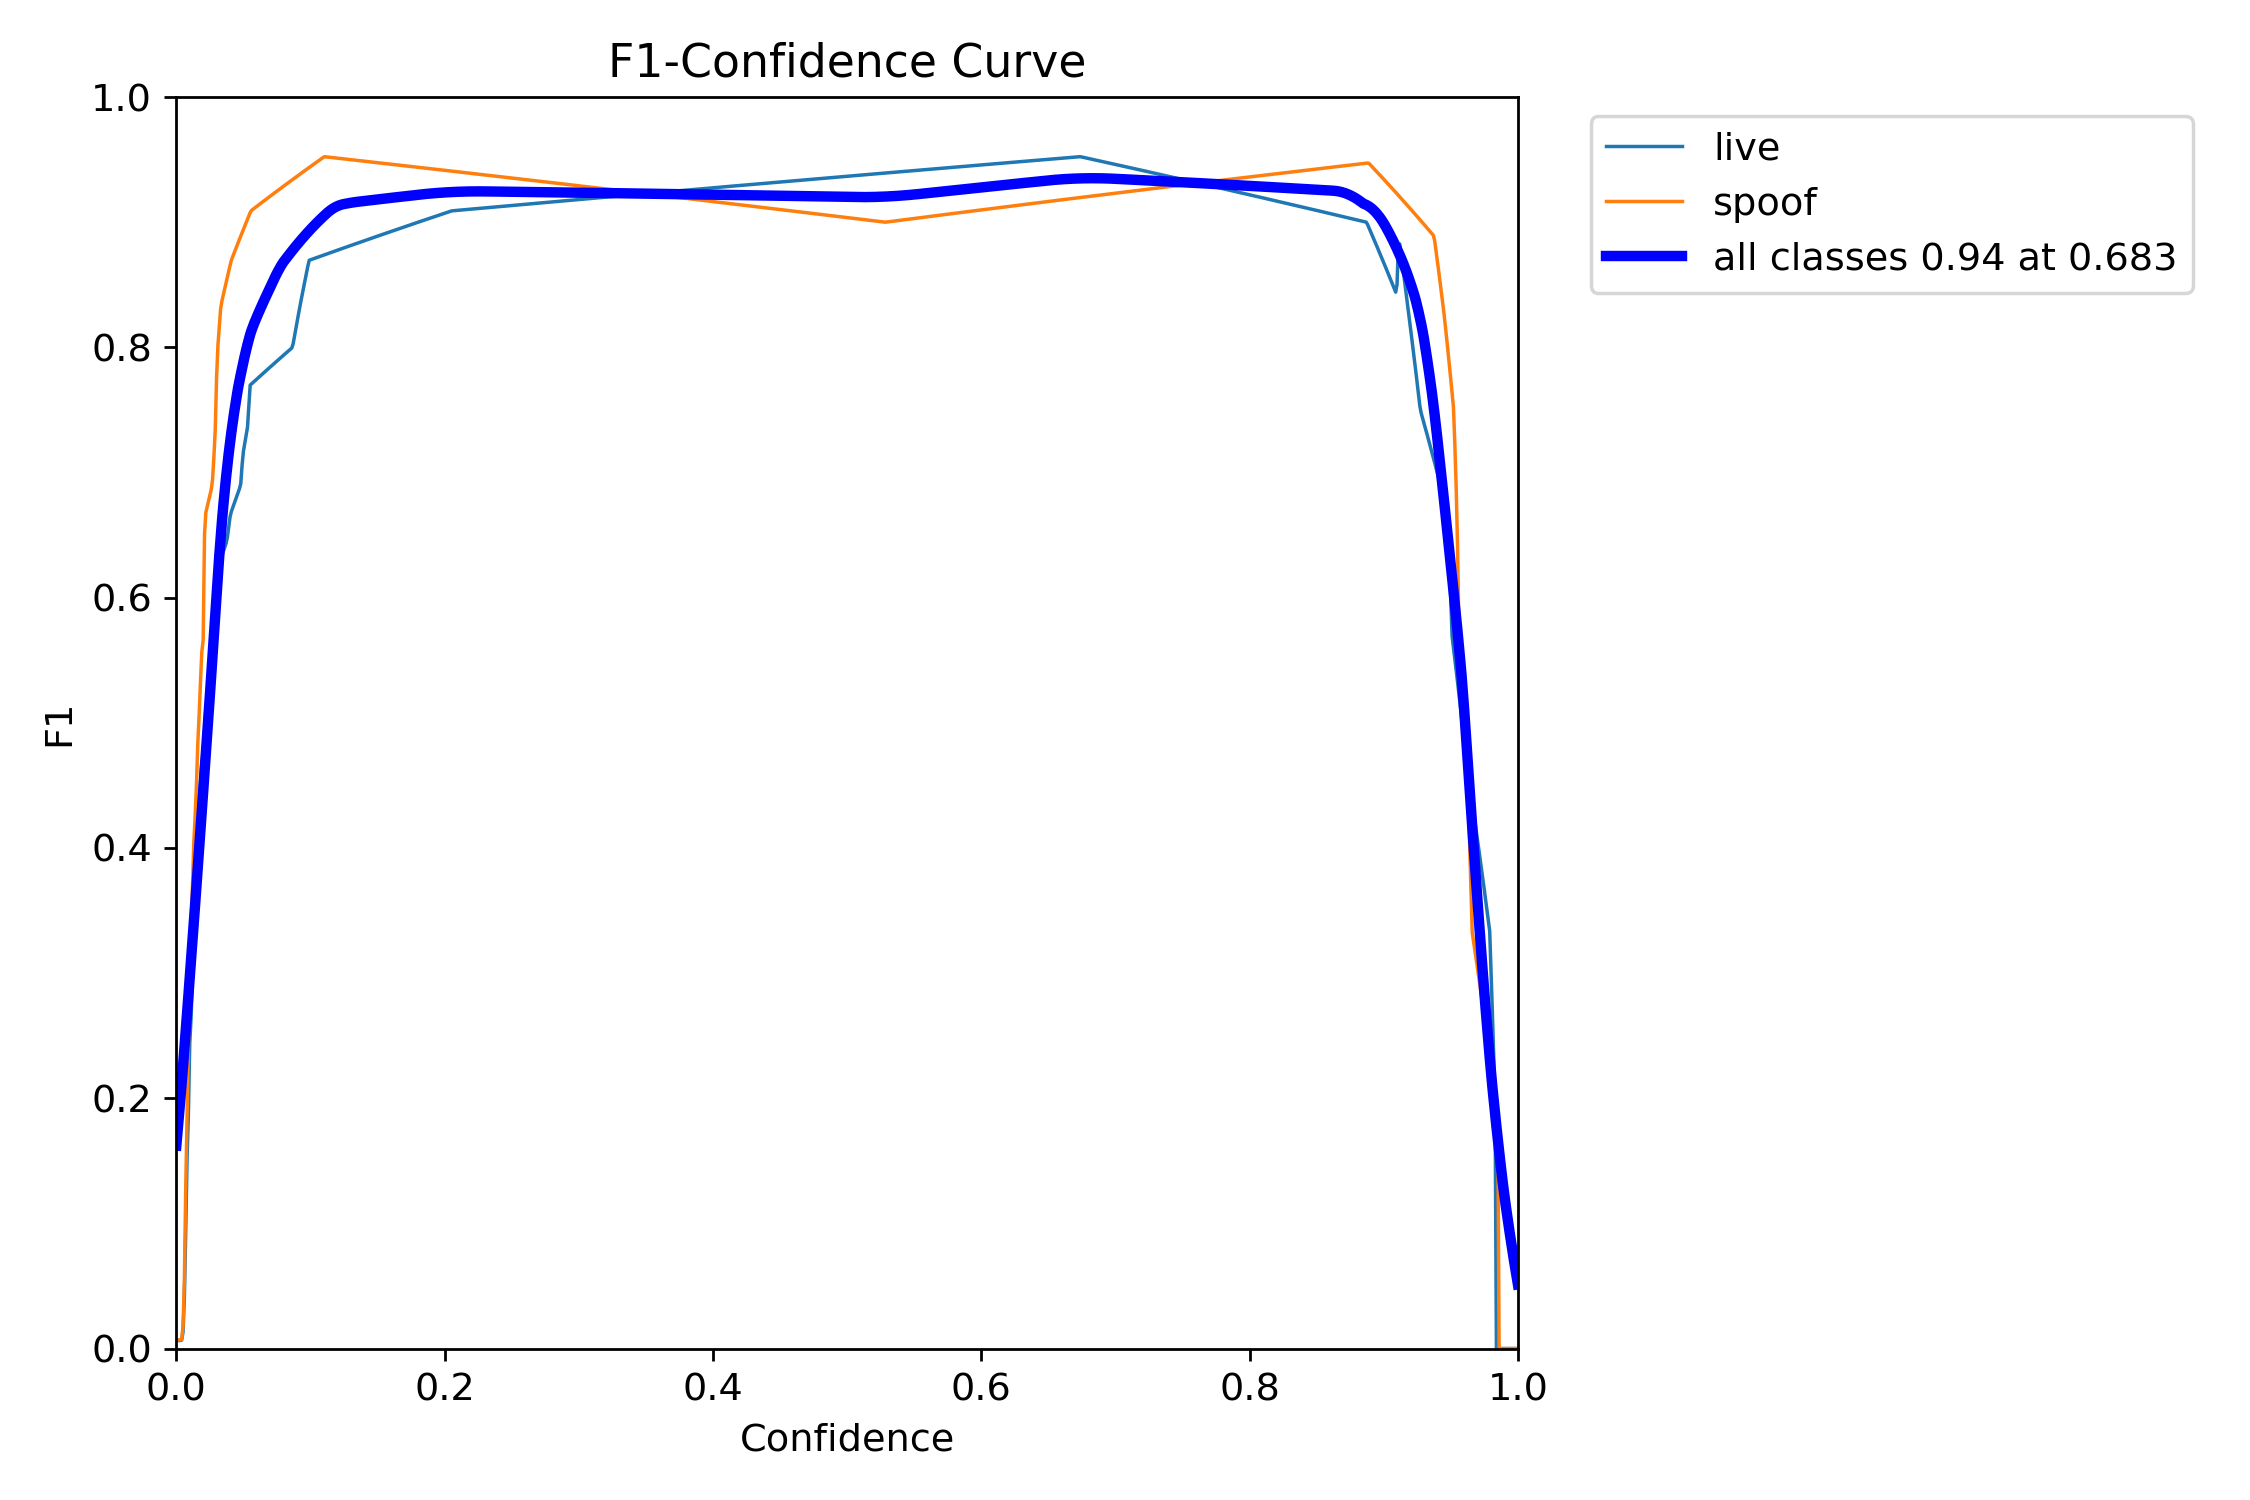

In [43]:
for img_name in ['results.png', 'P_curve.png', 'R_curve.png', 'PR_curve.png', 'F1_curve.png']:
  display(Image(filename=f'{save_dir}/{img_name}', width=600))

### 3. Visualize on Validation Set

Out of the 20 samples in the validation set, two samples detected 1 *live* and 1 *spoof*. Overall, for most of the samples, the model can achieve at least 0.9 of confidence. It took 20.4ms for each sample for inferencing.


0: 640x640 1 spoof, 20.4ms
1: 640x640 1 spoof, 20.4ms
2: 640x640 1 spoof, 20.4ms
3: 640x640 1 spoof, 20.4ms
4: 640x640 1 spoof, 20.4ms
5: 640x640 1 live, 1 spoof, 20.4ms
6: 640x640 1 live, 20.4ms
7: 640x640 1 live, 20.4ms
8: 640x640 1 spoof, 20.4ms
9: 640x640 1 live, 20.4ms
10: 640x640 1 spoof, 20.4ms
11: 640x640 1 live, 20.4ms
12: 640x640 1 live, 20.4ms
13: 640x640 1 spoof, 20.4ms
14: 640x640 1 live, 20.4ms
15: 640x640 1 live, 1 spoof, 20.4ms
16: 640x640 1 spoof, 20.4ms
17: 640x640 1 live, 20.4ms
18: 640x640 1 live, 20.4ms
19: 640x640 1 live, 20.4ms
Speed: 4.2ms preprocess, 20.4ms inference, 42.0ms postprocess per image at shape (1, 3, 640, 640)


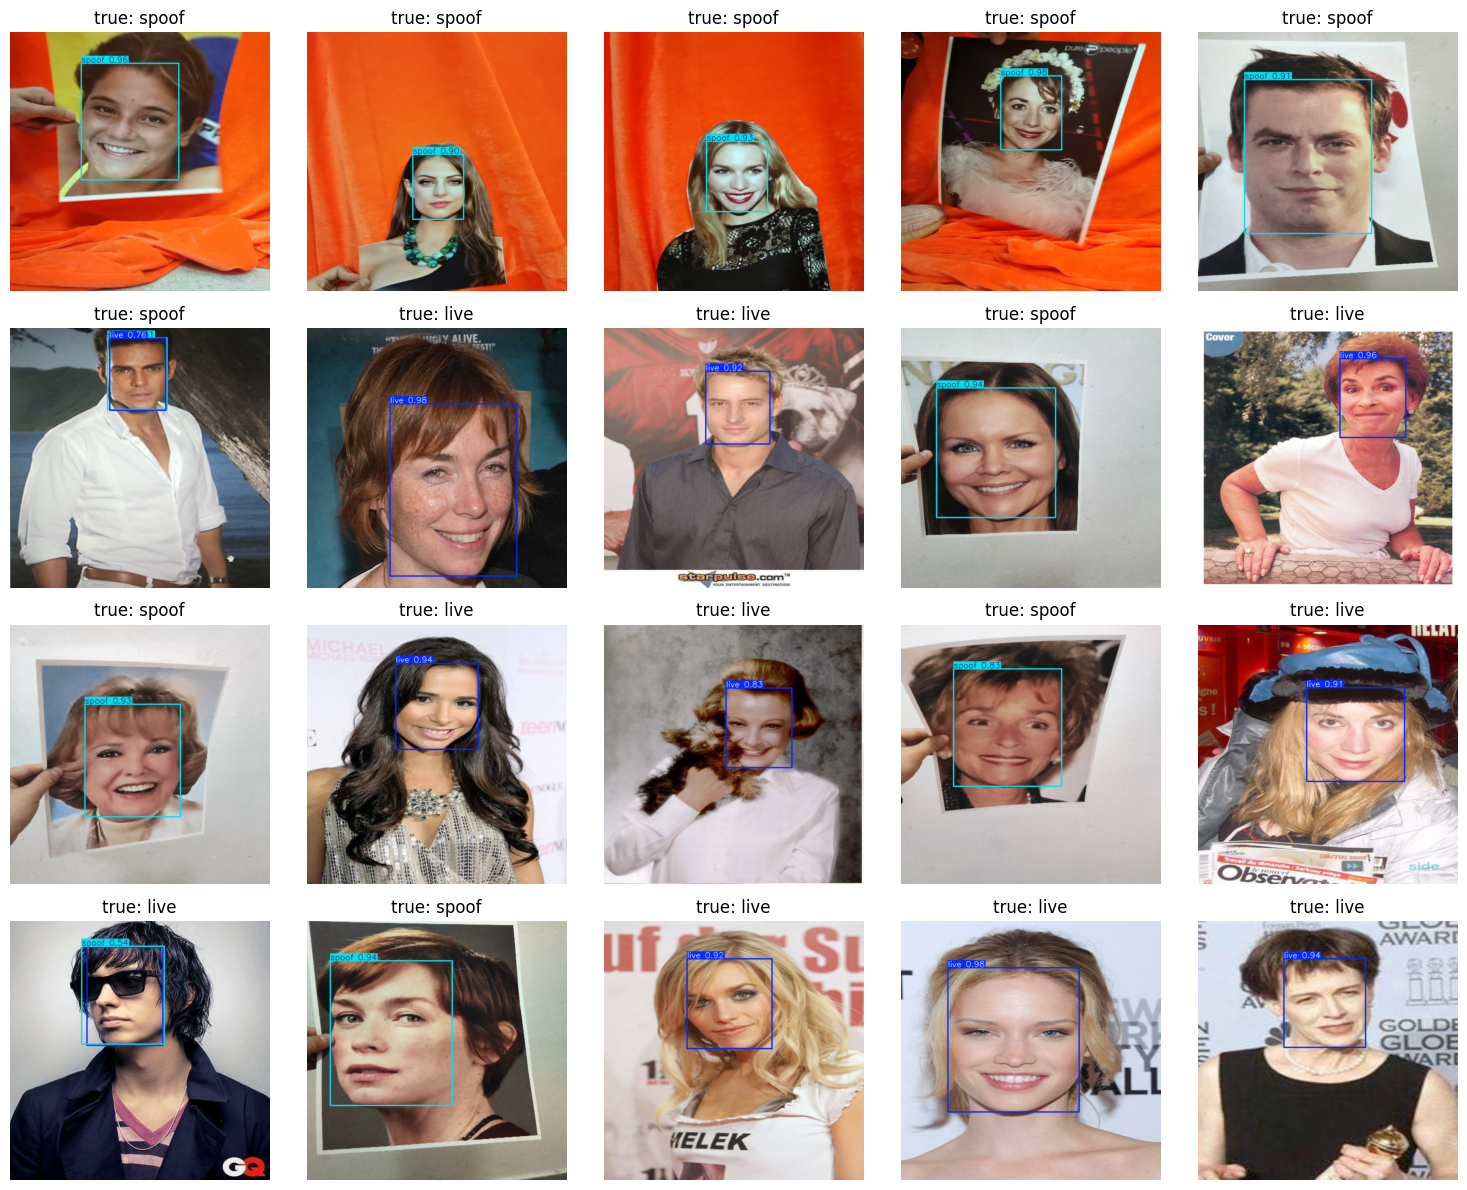

In [11]:
model = YOLO(f'{save_dir}/weights/best.pt')  

# Run batched inference on a list of images
image_folder = f'{dataset_processed_path}/images/val'
label_folder = f'{dataset_processed_path}/labels/val'
image_files = [os.path.join(image_folder, file) for file in sorted(os.listdir(image_folder))]
label_files = [os.path.join(label_folder, file) for file in sorted(os.listdir(label_folder))]
results = model(image_files)  # return a list of Results objects

num_images = len(image_files)
cols = 5
rows = (num_images + cols - 1) // cols  # Calculate the number of rows needed
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
axes = axes.flatten()

# Process results and plot each image
for i, result in enumerate(results):
    # Load real label
    with open(label_files[i], 'r') as file:
        line = file.readline().strip().split()
        label = 'spoof' if int(line[0]) else 'live'

    # Draw bounding boxes and labels on the image
    axes[i].imshow(cv2.cvtColor(result.plot(), cv2.COLOR_BGR2RGB))
    axes[i].axis('off')
    axes[i].set_title(f'true: {label}')

# Hide any remaining empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## E) EVALUATION
- test sets can be found at `data/datasets/test`

Out of the 20 samples in the test set, one fail to detect an object when the ground truth is *live*, and one detected two *spoof* objects when the ground truth is *spoof*. Overall, for most of the samples, the model can achieve at least 0.9 of confidence. It took 21.9ms for each sample for inferencing.


0: 640x640 1 spoof, 21.9ms
1: 640x640 1 spoof, 21.9ms
2: 640x640 1 spoof, 21.9ms
3: 640x640 (no detections), 21.9ms
4: 640x640 1 spoof, 21.9ms
5: 640x640 1 spoof, 21.9ms
6: 640x640 1 live, 21.9ms
7: 640x640 1 spoof, 21.9ms
8: 640x640 1 spoof, 21.9ms
9: 640x640 1 spoof, 21.9ms
10: 640x640 2 spoofs, 21.9ms
11: 640x640 1 spoof, 21.9ms
12: 640x640 1 live, 21.9ms
13: 640x640 1 spoof, 21.9ms
14: 640x640 1 live, 21.9ms
15: 640x640 1 live, 21.9ms
16: 640x640 1 spoof, 21.9ms
17: 640x640 1 live, 21.9ms
18: 640x640 1 spoof, 21.9ms
19: 640x640 1 spoof, 21.9ms
Speed: 3.5ms preprocess, 21.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


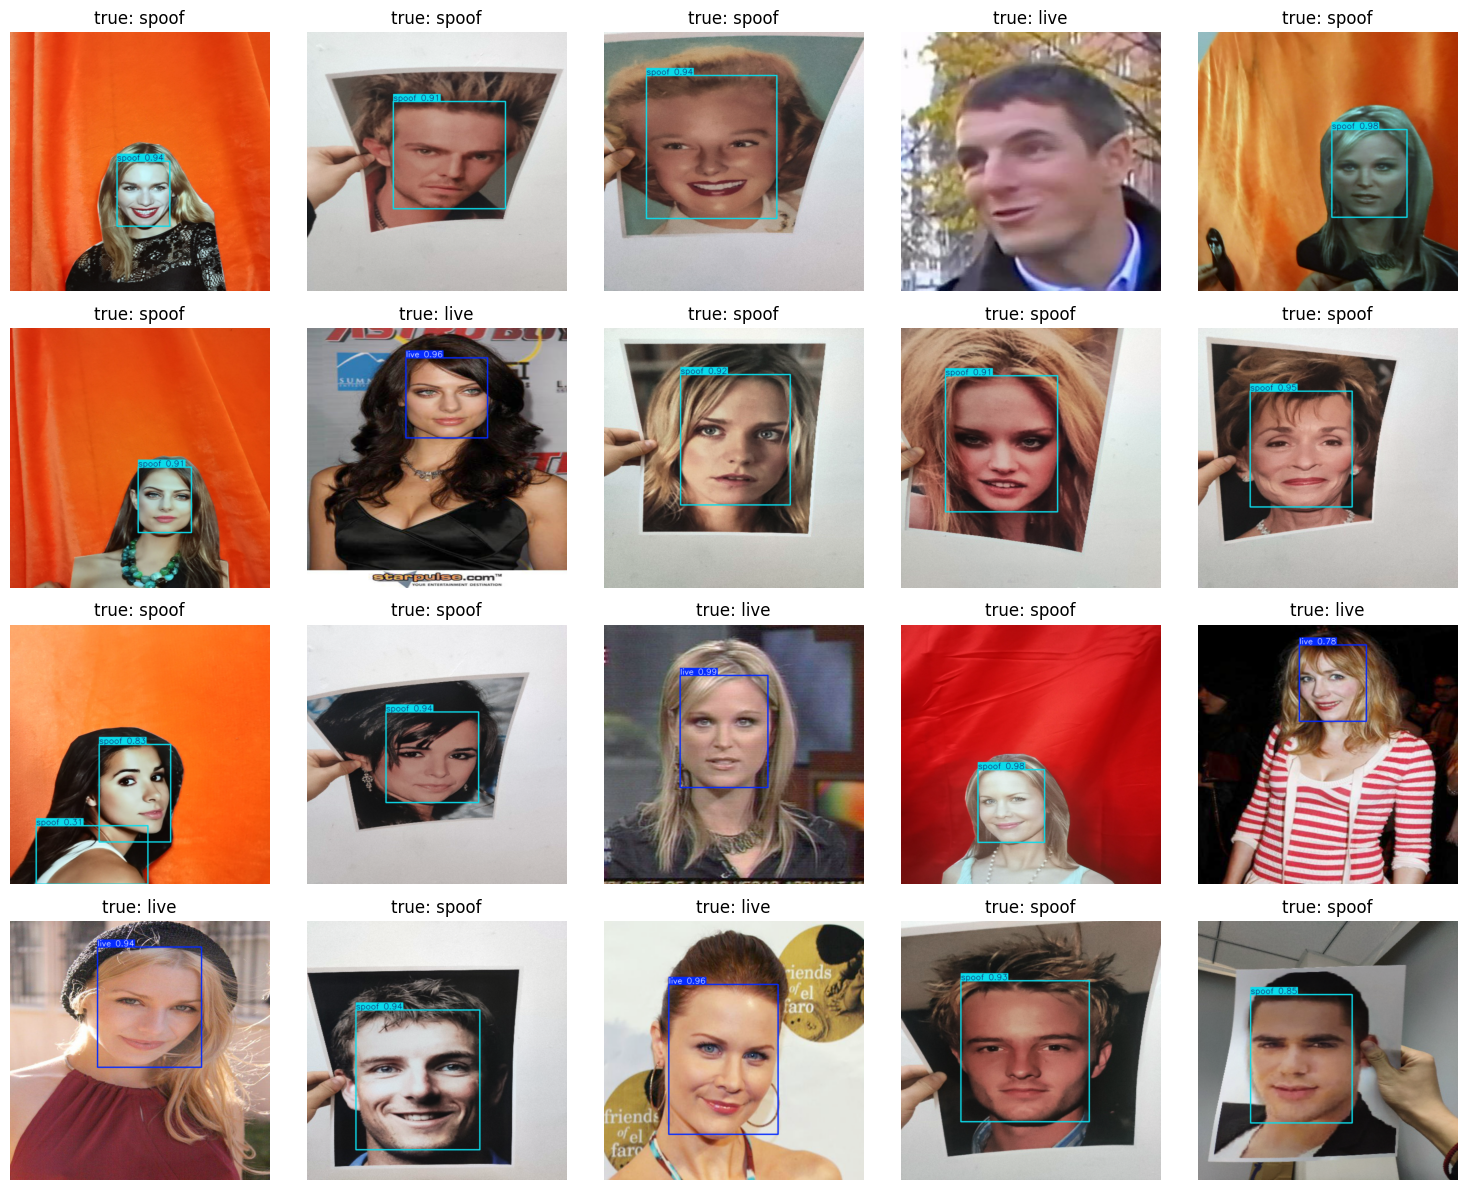

In [43]:
model = YOLO(f'{save_dir}/weights/best.pt')  

# Run batched inference on a list of images
image_folder = f'{dataset_processed_path}/images/test'
label_folder = f'{dataset_processed_path}/labels/test'
image_files = [os.path.join(image_folder, file) for file in sorted(os.listdir(image_folder))]
label_files = [os.path.join(label_folder, file) for file in sorted(os.listdir(label_folder))]
results = model(image_files)  # return a list of Results objects

num_images = len(image_files)
cols = 5
rows = (num_images + cols - 1) // cols  # Calculate the number of rows needed
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
axes = axes.flatten()

# Process results and plot each image
for i, result in enumerate(results):
    # Load real label
    with open(label_files[i], 'r') as file:
        line = file.readline().strip().split()
        label = 'spoof' if int(line[0]) else 'live'

    # Draw bounding boxes and labels on the image
    axes[i].imshow(cv2.cvtColor(result.plot(), cv2.COLOR_BGR2RGB))
    axes[i].axis('off')
    axes[i].set_title(f'true: {label}')

# Hide any remaining empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## F) CONCLUSION AND IMPROVEMENTS

- Please conclude your work based on all the previous sections. You can use  code, picture or written reasonings.
- example : The model achieves 90% mAP50

YOLOv8-Nano by Ultralytics is chosen as the network architecture, as the model is to be deployed on edge devices. During training it is fine-tuned on a pretrained model, which is trained on the COCO dataset. 

For the anti-spoofing task, the two classes present are *live* and *spoof*. There are a total of 160 samples in the dataset, the train-val-test split ratio is 75:12.5:12.5, the image and the corresponding bounding boxes and the label is provided in the dataset. The bounding box is represented as center coordinates (x_center, y_center, width, height). 

Since YOLOv8 requires images to be resized to a standard size, e.g. 640x640 pixels for training and inference, all of the images in the dataset are resized to 640x640 to ensure that the input dimensions are consistent. The corresponding center coordinates of the bounding box is normalized relative to the height or the width of the image.

After image resizing, 10 training samples were selected, in order to visualize the preprocessed data has the correct bounding boxes displayed. 

Confusion matrix was plotted to visualize the number of false postives (FPs) and false negatives (FNs) of the model. Precision-confidence curve, recall-confidence curve, F1-confidence curve, precision-recall curve were plotted to visualize the performance of the model at different thresholds. The losses of YOLOv8, box_loss, cls_loss, dfl_loss on both the training and validation set is plotted to inspect whether the losses decrease gradually as well as monitoring the occurence of overfitting. Offline evaluation metrics like precision, recall, mAP50, and mAP50-95 are evaluated to see whether the model achieves a good performance. At the 30th epoch, the model achieves 0.9355, 0.9500, 0.9814, 0.8311 on precision, recall, mAP50, and mAP50-95, respectively.

After offline evaluation, before model deployment, the model is evaluated on the test set, the results are visualized. 

## G) BONUS POINTS
- Further improve model accuracy
- Further improve model size and inference speed
- Model conversion (to ONNX / TFLite)
- Model serving (FastAPI / Streamlit)
- Dockerization
- Etc.


> Note: You shall provide proof of your improvements.


To improve the accuracy of YOLOv8, a larger variant of the YOLO model results in having more parameters and can capture more complex patterns in the data, leading to higher accuracy. Yet, this comes at a cost, which is increased model size and lower inference speed due to the higher computational requirements. Another possible approach is to perform data augmentation on the training dataset, in order to improve the ability of the model to generalize well on unseen data.

In [14]:
# Export to onnx
path = model.export(format="onnx", imgsz=640, half=True)

Ultralytics YOLOv8.2.74  Python-3.9.19 torch-2.4.0+cu124 CPU (Intel Core(TM) i5-10210U 1.60GHz)
WARNING  half=True only compatible with GPU export, i.e. use device=0

PyTorch: starting from '..\runs\detect\train\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (6.0 MB)

ONNX: starting export with onnx 1.15.0 opset 19...
ONNX: export success  2.9s, saved as '..\runs\detect\train\weights\best.onnx' (11.7 MB)

Export complete (6.5s)
Results saved to C:\Users\User\OneDrive - sjtu.edu.cn\SJTU\Road to Machine Learning Engineer\Job Tech Assessment\wise ai\runs\detect\train\weights
Predict:         yolo predict task=detect model=..\runs\detect\train\weights\best.onnx imgsz=640  
Validate:        yolo val task=detect model=..\runs\detect\train\weights\best.onnx imgsz=640 data=dataset.yaml  
Visualize:       https://netron.app


Dockerization is achieved with Docker, firstly define the Dockerfile, then build the Docker image, and lastly run the Docker container. Details on the usage of Docker could be found at `README.md`.

Model serving with Streamlit could be found at app.py. 

Link: https://junwai7159-anti-spoofing-app-3onp8m.streamlit.app/